## Comparing Basin Averaged AORC and PRISM Precipitation for the Logan River Watershed 

**Authors**:  
- Tony Castronova <acastronova@cuahsi.org>  
- Irene Garousi-Nejad <igarousi@cuahsi.org>  

**Last Updated**: 05.08.2023

**Description**:  

This notebook compares AORC v1.1 and PRISM precipitation estimates for the Logan River watershed in Logan, Utah. AORC (version 1.1) forcing data is collected  from HydroShare's THREDDS server and subset for the Logan River watershed. PRISM data has been prepared in advance and stored in a HydroShare [resource](https://www.hydroshare.org/resource/709bc880194046e3b79b0da56ad090fa/).

*Analysis of Record for Calibration (AORC)*  
> The Analysis of Record for Calibration (AORC) is a gridded record of near-surface weather conditions covering the continental United States and Alaska and their hydrologically contributing areas. It is defined on a latitude/longitude spatial grid with a mesh length of ~800 m (30 arc seconds), and a temporal resolution of one hour. Elements include hourly total precipitation, temperature, specific humidity, terrain-level pressure, downward longwave and shortwave radiation, and west-east and south-north wind components. It spans the period from 1979 at Continental U.S. (CONUS) locations / 1981 in Alaska, to the near-present (at all locations). This suite of eight variables is sufficient to drive most land-surface and hydrologic models and is used to force the calibration run of the National Water Model (NWM).

*Parameter-elevation Regressions on Independent Slopes Model (PRISM)*
> The PRISM Climate Data from Oregon State University is a gridded product covering the Conterminous United States. It combines climate observations from a wide range of monitoring networks with sophisticated modeling techniques to establish a local climate-elevation relationship for each grid cell. This relationship is then utilized to estimate various climate variables such as precipitation. This dataset spans from 1895 to the present and can be used to analyze short- and long-term climate patterns. The PRISM dataset is widely used across multiple disciplines, such as hydrology, climatology, agriculture, and environmental sciences and its popularity stems from its high spatial resolution, long-term record, reliable data quality, and ease of accessibility. It is worth noting that the PRISM dataset is available at two distinct spatial scales. The 4 km version is accessible to the public, while a more refined 800 m resolution dataset is available for a fee. For our purposes, we will be utilizing the publicly available 4 km resolution dataset.




**Software Requirements**

This notebook was developed using the following software and operating system versions.

OS: MacOS Ventura 13.0.1  
> Python: 3.11.0   
netcdf4: 1.6.3   
xarray: 2023.4.2   
dask: 2023.4.1      
distributed: 2023.4.1    
matplotlib: 3.7.1  
pandas: 2.0.1    
cartopy: 0.21.1  
fiona: 1.9.3  
geopandas: 0.13.0    
rioxarray: 0.14.1  


The following commands should help you set up these dependencies
```
$ conda create -n nwm-env python=3.10.0

$ conda install -y -c pyviz -c conda-forge pynhd folium s3fs hvplot dask distributed zarr

```


---

## 1. Search AORC Forcing on HydroShare Thredds

The AORC Forcing data used in this notebook covers the Great Basin watershed from 2010-2019 and is stored in HydroShare's Thredds catalog:

https://thredds.hydroshare.org/thredds/catalog/aorc/data/v1.1/16/catalog.html




In [2]:
import os
import re
import numpy
import pyproj
import xarray
import pandas
import requests
import geopandas
import rioxarray 
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from shapely.geometry import MultiPolygon
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

Initialize a `dask` distributed local cluster. This is not required but is used to speed up computations by distributing tasks across multiple workers.

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52323,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.68 GiB
Comm: tcp://127.0.0.1:52343,Total threads: 4
Dashboard: http://127.0.0.1:52348/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:52326,


### 1. Read AORC Data from HydroShare Thredds

To discover the available data, we're reading an XML file and parsing its content. Using this information we create a list of URLs that can be loaded using `xarray` in later steps. This process is optional and can be bypassed by manually collecting these urls from the THREDDs interface via web browser. 

Identify the files in the catalog via the catalog.xml document. The following link provides a list of all available data for the HUC-2 region for the Great Basin; `HUC=16`. 
https://thredds.hydroshare.org/thredds/catalog/aorc/data/16/catalog.xml

In [4]:
catalog_base_url = 'https://thredds.hydroshare.org/thredds/catalog'
dods_base_url = 'https://thredds.hydroshare.org/thredds/dodsC'

Read the catalog.xml document and extract all `urlPath` attributes. We'll use the `urlPath` attribute to build the complete path to each file we want to access.

In [5]:
url = f'{catalog_base_url}/aorc/data/v1.1/16/catalog.xml'
root = ET.fromstring(requests.get(url).text)
ns = '{http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0}'

In [6]:
# use xpath top select all "dataset" elements.
elems = root.findall(f'.//{ns}dataset')

In [7]:
# loop through results and extract the "urlPath" attribute values
paths = []
for elem in elems:
    atts = elem.attrib
    if 'urlPath' in atts.keys():
        paths.append(f"{dods_base_url}/{atts['urlPath']}")

In [8]:
# use regex to isolate only files that end with ".nc"
paths = list(filter(re.compile("^.*\.nc$").match, paths))

Print out some information about the files that we've found. For example, the total number of files as well as the names for the first and last files. The names of the first and last files will give us the temporal range of data that's available.

In [9]:
print(f'Found {len(paths)} individual files')
print(f'The first file is named: {os.path.basename(paths[0])}')
print(f'The last file is named: {os.path.basename(paths[-1])}')

Found 12 individual files
The first file is named: 201001.nc
The last file is named: 201012.nc


Connect to the THREDDs server and load a single month of data to explore that variables and spatial extent that is available to us. Using the URLs stored in the `paths` variable, we can load the first file via index 0 (i.e. `paths[0]`):


In [11]:
ds = xarray.open_mfdataset(paths,
                           concat_dim='time',
                           combine='nested',
                           parallel=True,
                           chunks={'time': 10, 'x': 285, 'y':275},
                           engine='netcdf4')

X, Y = numpy.meshgrid(ds.x.values, ds.y.values)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))


# add crs to netcdf file
ds.rio.write_crs(ds.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                       y_dim="y",
                                       inplace=True,
                                       ).rio.write_coordinate_system(inplace=True)


# make sure the data is sorted by time
ds = ds.sortby('time')

## 2. Preview the AORC Forcing Data Covering the Great Basin


Display the variables that are contained in this file.

In [12]:
ds

<xarray.Dataset>
Dimensions:         (reference_time: 12, x: 855, y: 820, time: 8760)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2010-01-01 ... 2010-12-01
  * x               (x) float64 -1.93e+06 -1.929e+06 ... -1.077e+06 -1.076e+06
  * y               (y) float64 -3.335e+05 -3.325e+05 ... 4.845e+05 4.855e+05
  * time            (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
    crs             int32 0
    lon             (y, x) float64 -118.7 -118.7 -118.7 ... -110.9 -110.9 -110.9
    lat             (y, x) float64 34.5 34.5 34.51 34.51 ... 43.64 43.64 43.64
Data variables:
    LQFRAC          (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(1, 275, 285), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2010-01-15_04:00:00
    model_initialization_time:       2010-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    history:                         Wed Apr  5 16:20:19 2023: ncks /anvil/da...
    NCO:                             4.7.2
    DODS_EXTRA.Unlimited_Dimension:  time

Plot the `RAINRATE` variable for the first timestep across the entire grid domain. There are numerous ways to select data within an Xarray DataSet, for more information on see: https://docs.xarray.dev/en/stable/user-guide/indexing.html

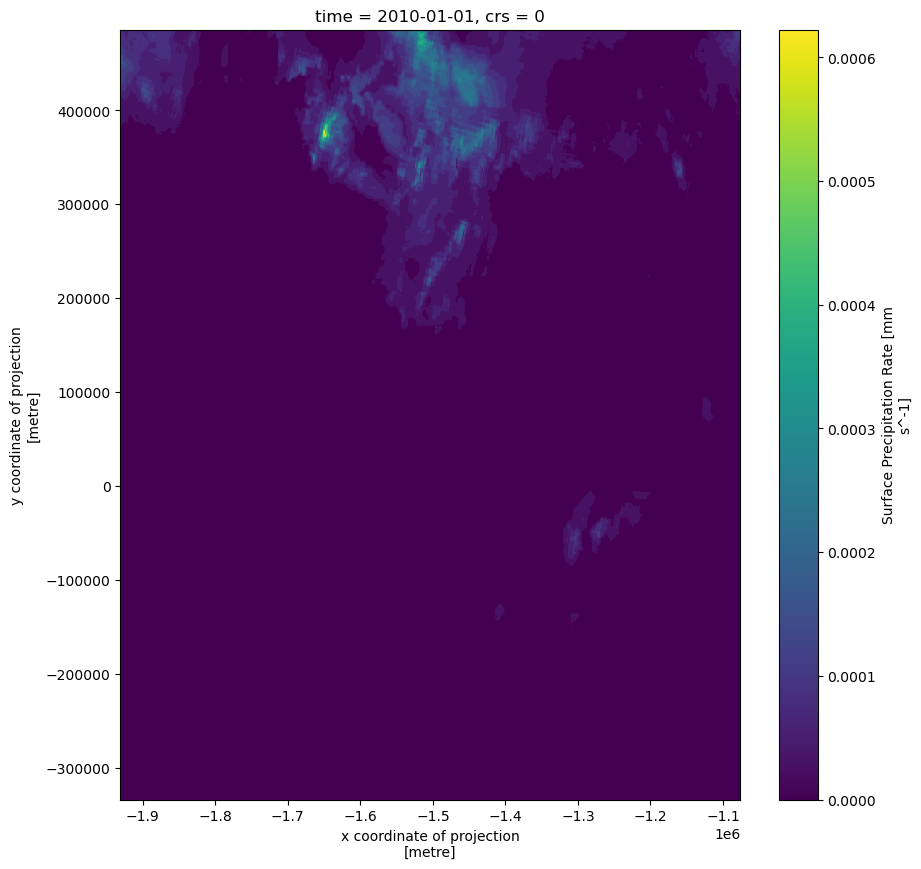

In [16]:
# plot RAINRATE for the entire spatial grid at time=0
ds.isel(time=0).RAINRATE.plot(figsize=(10, 10));

Load the Logan River Watershed shapefile using the `ShapelyFeature` function from the `Cartopy` Python package and preview it over the incoming longwave radiation (`LWDOWN`) for a single time step from AORC gridded data.

In [13]:
mp = MultiPolygon(Reader('logan-watershed-huc12.shp').geometries())

# read the geometries for plotting
shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')

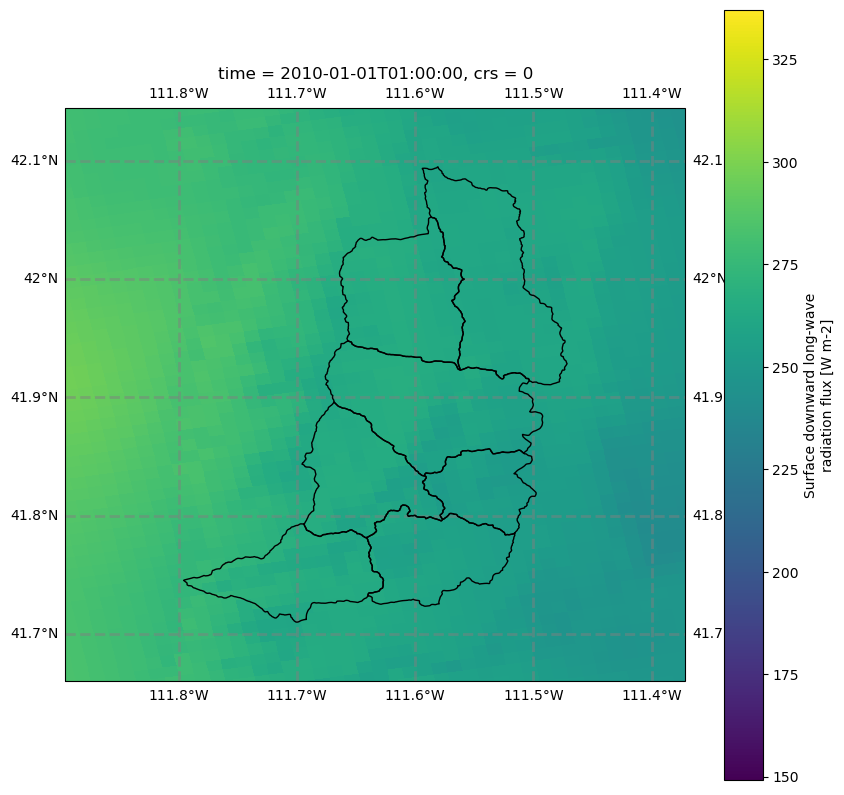

In [18]:
# plot the shapefile over the AORC data

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# plot LWDOWN at the first timesteop
ds.isel(time=1).LWDOWN.plot(
               ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat",
               zorder=2)

shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(shape_feature, zorder=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');

# adjust the map boundary
xmin, ymin, xmax, ymax = mp.bounds
dx, dy = (0.1, 0.05)
ax.set_ylim([ymin - dy, ymax + dy]);
ax.set_xlim([xmin - dx, xmax + dx]);

ax.set_aspect('equal');
ax.coastlines();
plt.show()


## 2. Subset AORC to the Logan River Watershed.

The obtained AORC data encompasses the Great Basin region, which exceeds the size of the Logan River watershed. To narrow down the data to our desired spatial extent, we will utilize the watershed shapefile for subsetting.  It is crucial to verify that both the AORC dataset and the watershed shapefile share the smae projected coordinate system. This alignment is essential to ensure accurate and reliable subsetting of the data.

In [14]:
# use the geopandas packate to read the watershed shapefile and to prepare geometries for spatial averaging 
gdf = geopandas.read_file('logan-watershed-huc12.shp')

# define a target coordinate system and convert the geometry data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

# use rioxarray to clip the gridded AORC to the watershed boundary.
ds = ds.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False)

Plot the result

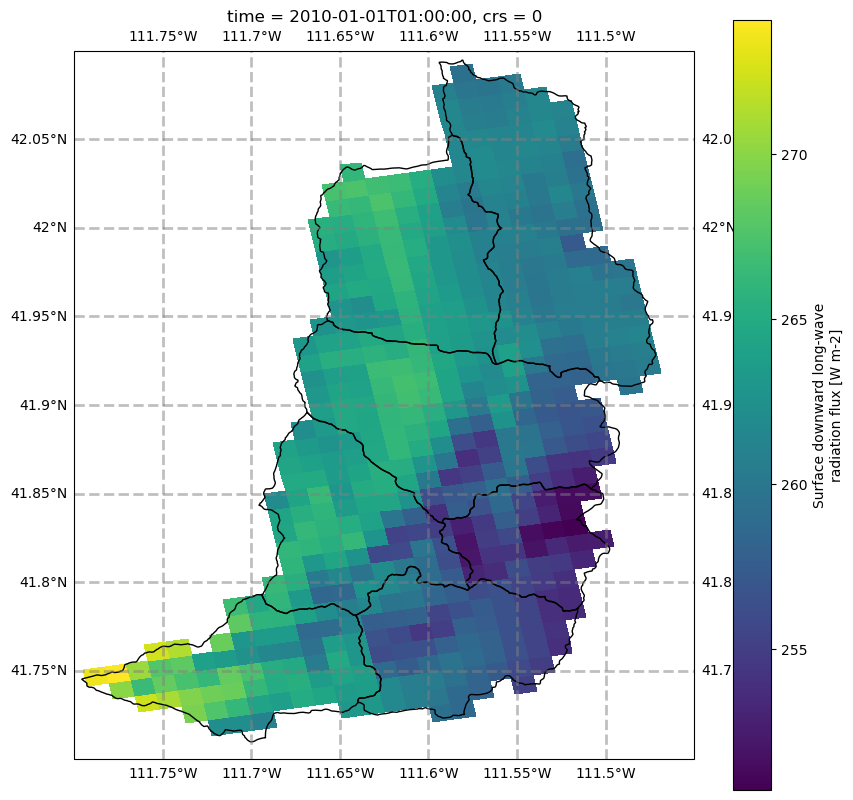

In [20]:
# visualize the subset using cartopy
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(shape_feature, zorder=1)

# plot LWDOWN at the first timesteop
ds.isel(time=1).LWDOWN.plot(
      ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat",
     zorder=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.set_ylim([41.70, 42.10]);
ax.set_xlim([-111.80, -111.45]);
ax.set_aspect('equal');
ax.coastlines();

## 3. Compute the Spatial Average Daily Precipitation across the Watershed

We will now focus on the first three months of the water year 2011 (i.e., starting on Oct 1, 2010 to the end of Dec 2010) and then partition the data into smaller pieces using the `chunk` function. 

In [15]:
# define the start and end dates for the period of interest and subset the data
st = '2010-10-01'
et = '2010-12-31'
data = ds.RAINRATE.loc[dict(time=slice(st, et))]

In [16]:
# chunck the dataset automatically based on the available system resources and data size. 
data = data.chunk(chunks='auto')

Let's collect the subset of data we obtained above into memory before we do an additional processing to ensure that computations on the data variable are optimized for performance. The following cell uses `Dask` (a parallel computing library) to persist and monitor the progress of our computation. The `.persist()` operation tells `Dask` to keep the data in memory and persist it across the cluster if one is available. By persisting the data, subsequent computations can be performed more efficiently, as the data is readily **available in memory**. The `progress()` function creates a progress bar that displays the status of the ongoing computations. 

In [17]:
from dask.distributed import progress
d = data.persist()
progress(d)

VBox()

Now, we will compute the spatially averaged daily precipitation by processing the gridded hourly precipitation rates. This task involves three steps: (1) resampling the hourly data to obtain daily total, (2) subsequently computing the average over the spatial dimension, and (3) covert units from $mm/s$ to $mm/day$.

In [18]:
basin_ave_precip = d.resample(time='1D').sum().mean(dim=['x','y']) * 3600

## 4. Compare the AORC precipitation data with the PRISM precipitation

PRISM data was downloaded from HydroShare. Let's load these data using `Pandas`.

In [19]:
df = pandas.read_csv('Daily_PRISM_Precipitation_in_2010_for_LoganRiverWatershed.csv')
df['Date'] = pandas.to_datetime(df.Date)
df.set_index('Date', inplace=True)

Compare AORC and PRISM daily precipitation.

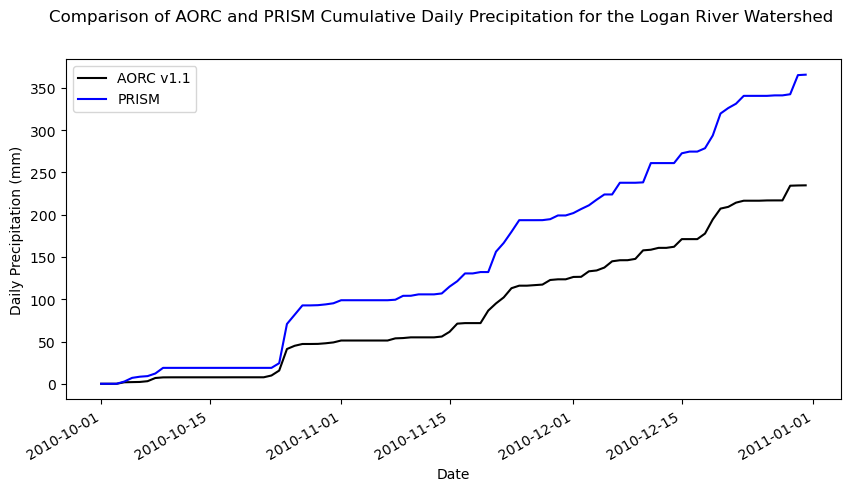

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(basin_ave_precip.time, basin_ave_precip.cumsum(), label='AORC v1.1', color='k');

df[slice(st, et)]['Precipitation (mm)'].cumsum().plot(ax=ax, label='PRISM', color='b')

ax.set_ylabel('Daily Precipitation (mm)');
ax.set_xlabel('Date');
fig.suptitle('Comparison of AORC and PRISM Cumulative Daily Precipitation for the Logan River Watershed');
plt.legend();